In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from ase.io import read

import abtem

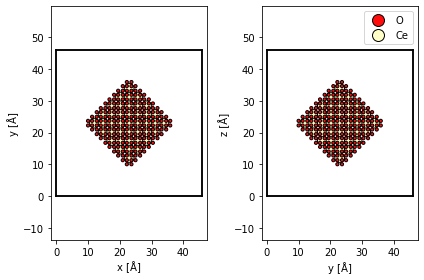

In [2]:
atoms = read(r'C:\Users\Joshu\Desktop\Models\Ceria.cfg')

'prod'

potential = abtem.Potential(atoms, gpts=(512, 512))

fig, (ax1, ax2) = plt.subplots(1, 2)
abtem.show_atoms(atoms, ax=ax1)
abtem.show_atoms(atoms, legend=True, ax=ax2, plane="yz")
plt.tight_layout()

In [3]:
s_matrix = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    semiangle_cutoff=20,
)

In [4]:
s_matrix_array = s_matrix.build()

s_matrix_array.compute()

[########################################] | 100% Completed | 174.50 s


In [5]:
waves = s_matrix_array.waves[:100:20].compute()

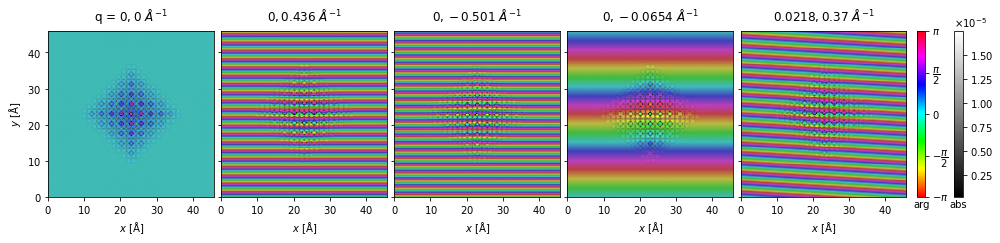

In [6]:
visualization = waves.complex_images().show(
    explode=True, figsize=(16, 5), cmap="hsv", cbar=True, common_color_scale=True
);

In [7]:
sampling = abtem.transfer.nyquist_sampling(s_matrix.semiangle_cutoff, s_matrix.energy)

scan = abtem.GridScan(
    start=(0, 0),
    end=(1, 1),
    fractional=True,
    potential=potential,
    sampling=sampling,
)

print(f"Number of probe positions: {len(scan)}")
print(f"Number of plane waves: {len(s_matrix)}")
print(f"Ratio: {len(scan) / len(s_matrix):.1f}")

Number of probe positions: 15625
Number of plane waves: 3125
Ratio: 5.0


In [8]:
detector = abtem.AnnularDetector(inner=50, outer=150)

measurement = s_matrix.scan(scan=scan, detectors=detector).compute()

[####################################### ] | 98% Completed | 170.27 ss


RuntimeError: Outer integration limit cannot exceed the maximum simulated angle (150 mrad > 110.17630811264821 mrad), please increase the number of grid points.

In [9]:
interpolated_measurement = measurement.interpolate(0.1).gaussian_filter(0.3)

interpolated_measurement.show();

NameError: name 'measurement' is not defined

In [10]:
s_matrix_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    semiangle_cutoff=20,
    interpolation=(1, 2),
)

s_matrix_more_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    semiangle_cutoff=20,
    interpolation=(2, 4),
)

s_matrix_very_interpolated = abtem.SMatrix(
    potential=potential,
    energy=150e3,
    semiangle_cutoff=20,
    interpolation=(4, 8),
)

In [11]:
measurement_interpolated = s_matrix_interpolated.scan(
    scan=scan,
    detectors=detector,
).compute()
measurement_more_interpolated = s_matrix_more_interpolated.scan(
    scan=scan,
    detectors=detector,
).compute()
measurement_very_interpolated = s_matrix_very_interpolated.scan(
    scan=scan,
    detectors=detector,
).compute()

[######################################  ] | 96% Completed | 219.73 ss


RuntimeError: Outer integration limit cannot exceed the maximum simulated angle (150 mrad > 109.53200221725261 mrad), please increase the number of grid points.

In [12]:
interpolated_measurements = (
    abtem.stack(
        [
            measurement,
            measurement_interpolated,
            measurement_more_interpolated,
            measurement_very_interpolated,
        ],
        (
            "(fn, fm) = (1, 1)",
            "(fn, fm) = (1, 2)",
            "(fn, fm) = (2, 4)",
            "(fn, fm) = (4, 8)",
        ),
    )
    .interpolate(0.1)
    .gaussian_filter(0.3)
)

interpolated_measurements.show(
    explode=True,
    figsize=(10, 6),
    common_color_scale=True,
    cbar=True,
);

NameError: name 'measurement' is not defined

In [13]:
errors = abtem.stack(
    [
        interpolated_measurements[0] - interpolated_measurement,
        interpolated_measurements[1] - interpolated_measurement,
        interpolated_measurements[2] - interpolated_measurement,
        interpolated_measurements[3] - interpolated_measurement,
    ],
    (
        "(fn, fm) = (1, 1)",
        "(fn, fm) = (1, 2)",
        "(fn, fm) = (2, 4)",
        "(fn, fm) = (4, 8)",
    ),
)


visualization = (
    errors.gaussian_filter(0.3)
    .interpolate(0.1)
    .show(
        explode=True,
        figsize=(10, 6),
        common_color_scale=True,
        cbar=True,
        cmap="seismic",
        vmin=-0.02,
        vmax=0.02,
    )
);

NameError: name 'interpolated_measurements' is not defined

[########################################] | 100% Completed | 123.77 ms
[########################################] | 100% Completed | 118.80 ms
[########################################] | 100% Completed | 106.44 ms
[########################################] | 100% Completed | 127.90 ms


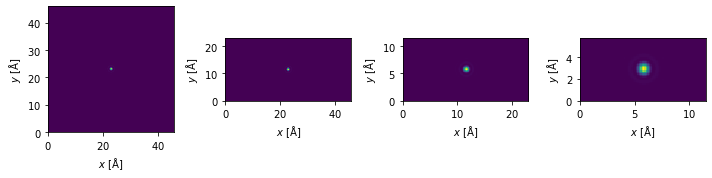

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 4))

s_matrix.dummy_probes().show(ax=ax1)

s_matrix_interpolated.dummy_probes().show(ax=ax2)

s_matrix_more_interpolated.dummy_probes().show(ax=ax3)

s_matrix_very_interpolated.dummy_probes().show(ax=ax4)

plt.tight_layout();

In [15]:
defocus = -np.linspace(0, 80, 5)

ctf = abtem.CTF(defocus=defocus)

measurement_with_aberrations = s_matrix_interpolated.scan(
    scan=scan, detectors=detector, ctf=ctf
).compute()

measurement_with_aberrations.interpolate(0.1).gaussian_filter(0.3).show(
    explode=True,
    figsize=(10, 6),
);

[######################################  ] | 96% Completed | 220.53 ss


RuntimeError: Outer integration limit cannot exceed the maximum simulated angle (150 mrad > 109.53200221725261 mrad), please increase the number of grid points.

In [ ]:
measurement = s_matrix.scan(
    scan=scan, detectors=detector, max_batch_multislice = 20, max_batch_reduction = 200
)